## Basic PyTorch for Deep Learning

- Neuron = ฟังก์ชันเชิงเส้น 𝑧 = 𝑥𝑊 + 𝑏 แล้วค่อยใส่ activation ถ้ามี

- Perceptron (Rosenblatt) = Neuron + step function และใช้กติกาอัปเดตแบบ mistake-driven (ใช้ได้เฉพาะข้อมูล linear separable)

- MLP = ซ้อนหลายชั้น + activation ไม่เชิงเส้น (ReLU/SiLU/…): แก้ปัญหาไม่ linear ได้ เช่น XOR

### Install Libraries
- torch
- - PyTorch หลัก ใช้สร้างโมเดล Deep Learning, ทำคำนวณแบบ tensor (คล้าย NumPy แต่ optimized บน GPU), training neural network

- torchvision
- - เป็น extension สำหรับงาน Computer Vision เช่น โหลด datasets (MNIST, CIFAR, ImageNet), มี transforms (resize, normalize) และโมดูลโมเดลสำเร็จรูป (ResNet, VGG ฯลฯ)
 
- torchmetrics 
- - เอาไว้ใช้คำนวณ metrics สำหรับประเมินโมเดล เช่น Accuracy, Precision, Recall, F1-score โดยออกแบบมาให้ใช้งานง่ายและทำงานร่วมกับ PyTorch Lightning หรือ training loop ปกติ
  
- matplotlib
- - library สำหรับ การ plot กราฟและ visualization เช่น แสดงผลการ training loss, accuracy per epoch, ดูรูปภาพใน dataset ฯลฯ

- numpy
- - library สำหรับการคำนวณเชิงตัวเลข (Numerical Computation) ใช้สำหรับจัดการ array และ matrix (ข้อมูลหลายมิติ) ได้อย่างมีประสิทธิภาพ และรองรับการคำนวณทางคณิตศาสตร์ต่าง ๆ

### Set Up Environments

In [82]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### Neuron
- single neuron สำหรับ binary classification ใช้ BCEWithLogitsLoss (รวม sigmoid ภายใน loss อยู่แล้ว)

In [83]:
# Input features
X = torch.tensor([
    [0.2, 0.1],
    [0.4, 0.3],
    [0.6, 0.8],
    [0.9, 0.7],
], dtype=torch.float32)

# Target labels
y = torch.tensor([0., 0., 1., 1.], dtype=torch.float32)

In [84]:
X, y

(tensor([[0.2000, 0.1000],
         [0.4000, 0.3000],
         [0.6000, 0.8000],
         [0.9000, 0.7000]]),
 tensor([0., 0., 1., 1.]))

In [85]:
# Model: single neuron
class Neuron(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.linear = nn.Linear(in_features, 1) # output logits
    def forward(self, x):
        return self.linear(x).squeeze(1)  # logits

In [86]:
model = Neuron(in_features=2) # 2 input features
criterion = nn.BCEWithLogitsLoss() # for binary classification
optimizer = torch.optim.SGD(model.parameters(), lr=0.5) # SGD optimizer

In [87]:
# Training loop
EPOCHS = 200
history = {"loss": [], "acc": []}

# Train the model
for epoch in range(EPOCHS):
    logits = model(X)
    loss = criterion(logits, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record metrics
    with torch.no_grad():
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float()
        acc = (preds == y).float().mean().item()

    # Append metrics to history
    history["loss"].append(loss.item())
    history["acc"].append(acc)

In [104]:
# Predict
with torch.no_grad():
    probs = torch.sigmoid(model(X))
    preds = (probs >= 0.5).float()

# Results
print("probs:", probs.tolist())
print("preds:", preds.tolist())

probs: [0.02314797043800354, 0.6315706968307495, 0.4213704764842987, 0.9813711047172546]
preds: [0.0, 1.0, 0.0, 1.0]


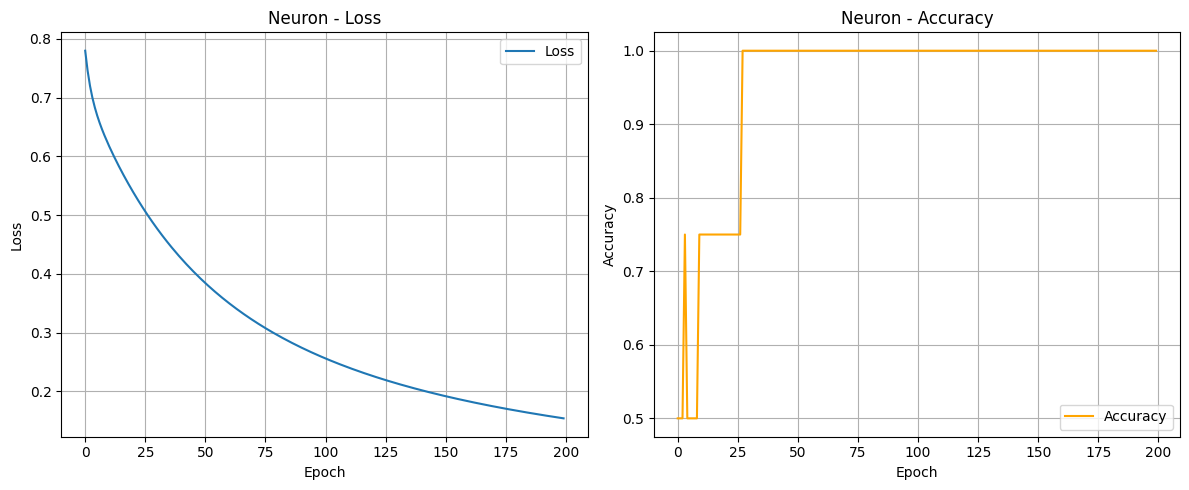

In [89]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history["loss"], label="Loss")
plt.title("Neuron - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history["acc"], color="orange", label="Accuracy")
plt.title("Neuron - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### Perceptron — Classical Rule (Step Function)

In [90]:
# Input features for AND logic gate
X = torch.tensor([[0,0],[0,1],[1,0],[1,1]], dtype=torch.float32)
y = torch.tensor([0,0,0,1], dtype=torch.float32)  # AND

In [91]:
X, y

(tensor([[0., 0.],
         [0., 1.],
         [1., 0.],
         [1., 1.]]),
 tensor([0., 0., 0., 1.]))

In [92]:
# Perceptron — Classical Rule (Step Function)
def perceptron_train(X, y, epochs=20, lr=1.0):
    w = torch.zeros(X.shape[1]) # weights
    b = torch.zeros(1) # bias
    errors_hist = [] # history of errors
    for _ in range(epochs):
        errors = 0 # count of errors in this epoch
        for xi, yi in zip(X, y): # for each sample
            a = torch.dot(xi, w) + b # activation
            y_hat = 1.0 if a.item() > 0 else 0.0 # step function
            update = lr * (yi.item() - y_hat) # weight update
            if update != 0.0: # if there is an error
                w += update * xi # update weights
                b += update # update bias
                errors += 1 # increment error count
        errors_hist.append(errors) # record errors for this epoch
    return w, b, errors_hist

In [93]:
w, b, history = perceptron_train(X, y, epochs=10)

In [94]:
# Train perceptron
def perceptron_predict(X, w, b):
    a = X @ w + b # shape: [N]
    return (a > 0).float()

In [95]:
print("w:", w.tolist(), "b:", b.item())
print("preds:", perceptron_predict(X, w, b).tolist())

w: [2.0, 1.0] b: -2.0
preds: [0.0, 0.0, 0.0, 1.0]


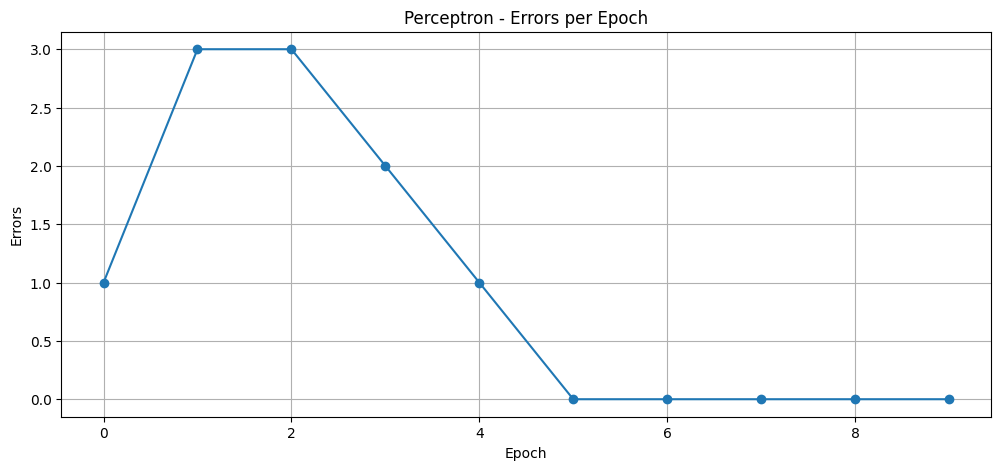

In [96]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 1, 1)
plt.plot(history, marker='o')
plt.title("Perceptron - Errors per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Errors")
plt.grid(True)

- ใช้ได้เฉพาะข้อมูลที่ แยกเส้นตรงได้ เท่านั้น (อย่าง XOR จะแพ้)
- step function ไม่ differentiable → ใช้กับ backprop ตรงๆ ไม่ได้
- ถ้าจะ “ฝึกแบบนุ่ม” ให้ใช้โลจิสติก (BCEWithLogitsLoss) แทน step

### MLP — Solve XOR Problem

In [97]:
# Dataset: XOR gate (not linear separable)
# Input features
X = torch.tensor([[0,0],[0,1],[1,0],[1,1]], dtype=torch.float32)

# Target labels
y = torch.tensor([0., 1., 1., 0.], dtype=torch.float32)

In [98]:
X, y

(tensor([[0., 0.],
         [0., 1.],
         [1., 0.],
         [1., 1.]]),
 tensor([0., 1., 1., 0.]))

In [99]:
# MLP — Solve XOR Problem
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(1)

In [100]:
# Instantiate model, loss function, optimizer
mlp = MLP()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.05)

In [101]:
# Training loop
EPOCHS = 2000
history = {"loss": [], "acc": []}

for epoch in range(EPOCHS):
    logits = mlp(X)
    loss = criterion(logits, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float()
        acc = (preds == y).float().mean().item()

    history["loss"].append(loss.item())
    history["acc"].append(acc)

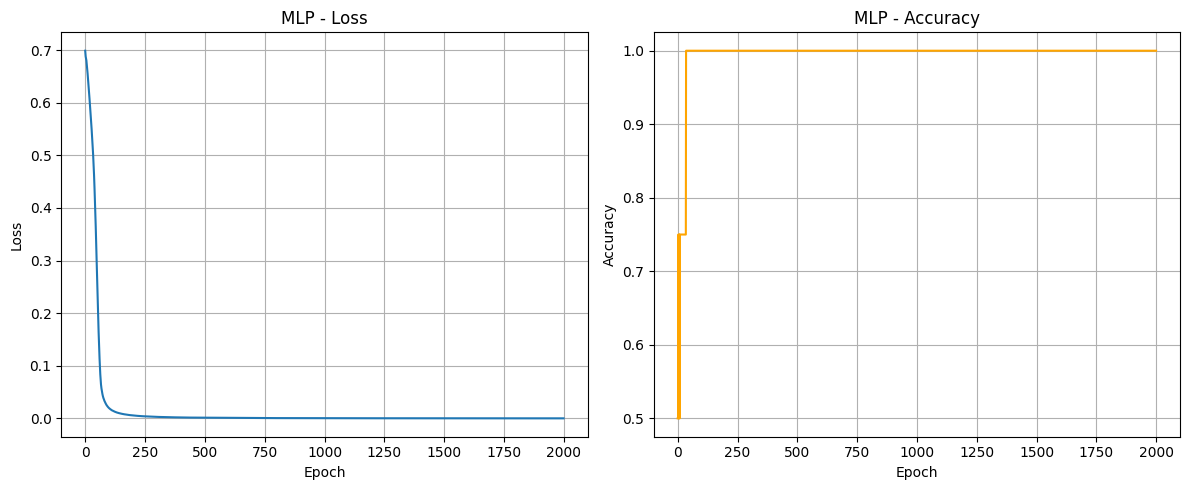

In [102]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history["loss"])
plt.title("MLP - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history["acc"], color="orange")
plt.title("MLP - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()


In [103]:
# Predict
with torch.no_grad():
    probs = torch.sigmoid(model(X))
    preds = (probs >= 0.5).float()
print("Final preds:", preds.tolist())

Final preds: [0.0, 1.0, 0.0, 1.0]


- ใช้ BCEWithLogitsLoss เสมอเวลาทำ binary classification ด้วย logits
- Hidden units 4 ตัวพอสำหรับ XOR; ปัญหาจริงปรับขนาด/ชั้นตามความยาก
- ถ้า loss ไม่ลง ลองลด LR, เพิ่ม epoch, หรือเปลี่ยน Init (set seed)